HYPOTHESIS TESTING PART

Hypothesis 1:  A larger production budget always translates to higher revenue.

Hypothesis 2: Certain genres or genre combinations perform better in terms of revenue.

Hypothesis 3: There is a correlation between runtime and revenue.

Hypothesis 4: Audience ratings (e.g., IMDb, Rotten Tomatoes) correlate with financial success (revenue).




In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

full_df_cleaned = pd.read_csv('full_df_with_tmdb_profit.csv')

full_df_cleaned = full_df_cleaned.dropna(axis=1, how='all')
full_df_cleaned = full_df_cleaned.dropna(axis=0, how='any')



def remove_outliers(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_filtered


def remove_outliers_multiple(df, columns):
    for column in columns:
        df = remove_outliers(df, column)
    return df

#filter the dataset from extreme outliers, they are not errors but will negatively affect the correctness of tests
df_filtered = remove_outliers_multiple(full_df_cleaned, ['tmdb_profit', 'runtimeMinutes','tmdb_revenue', 'tmdb_budget'])

full_df_cleaned = df_filtered
print(full_df_cleaned.shape)

(3036, 25)


Hypothesis 1

H₀: There is no relationship between production budget and revenue (i.e., the slope of the regression line is zero).

H₁: There is a positive relationship between production budget and revenue (i.e., the slope of the regression line is greater than zero).

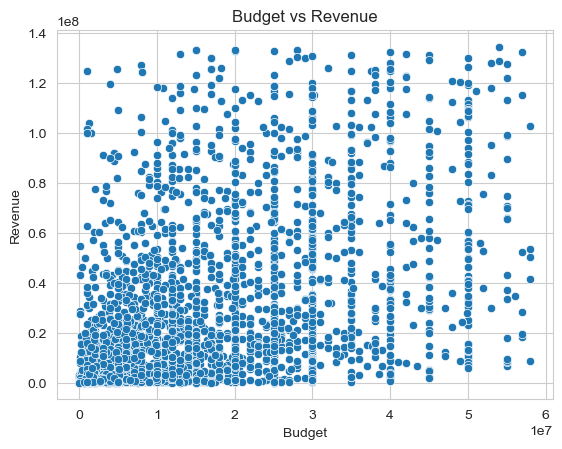

R-squared for budget vs revenue: 0.2505933235747412
Slope: 1.17531914752003, p-value: 2.555761385665728e-192
Reject H0: There is a significant positive relationship between budget and revenue.


In [98]:
def test_hypothesis_1(df):
    sns.scatterplot(x='tmdb_budget', y='tmdb_revenue', data=df)
    plt.title('Budget vs Revenue')
    plt.xlabel('Budget')
    plt.ylabel('Revenue')
    plt.show()

    # --- Linear Regression Model ---
    # Define predictor (X) and response (y) variables for the model.
    # A simple linear regression is performed to estimate the line of best fit.
    X = df[['tmdb_budget']]
    y = df['tmdb_revenue']
    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)

    # Compute the coefficient of determination (R²), which quantifies the proportion of variance
    # in revenue that can be explained by the budget. Values closer to 1 indicate a better fit.
    r_squared = r2_score(y, predictions)
    print(f'R-squared for budget vs revenue: {r_squared}')

    # --- Hypothesis Testing: Significance of Slope ---
    # Perform a t-test using scipy's linregress to assess whether the slope of the regression line
    # is significantly different from zero (i.e., if budget is a statistically significant predictor).
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['tmdb_budget'], df['tmdb_revenue'])
    print(f'Slope: {slope}, p-value: {p_value}')

    # --- Decision Rule Based on p-value ---
    # If the p-value is less than the significance level (α = 0.05), we reject the null hypothesis.
    # This suggests a statistically significant linear relationship exists between budget and revenue.
    if p_value < 0.05:
        print("Reject H0: There is a significant positive relationship between budget and revenue.")
    else:
        print("Do not reject H0: There is no significant relationship between budget and revenue.")
test_hypothesis_1(full_df_cleaned)

Hypothesis 2

H₀: There is no difference in average revenue among different genres or genre combinations.

H₁: At least one genre or genre combination has a different average revenue compared to others.

/var/folders/tj/gpd7f9kd1xlg123xhj0ht8f80000gn/T/ipykernel_17579/2363132732.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tmdb_revenue', y='genres', data=genre_revenue_sampled, palette='viridis')


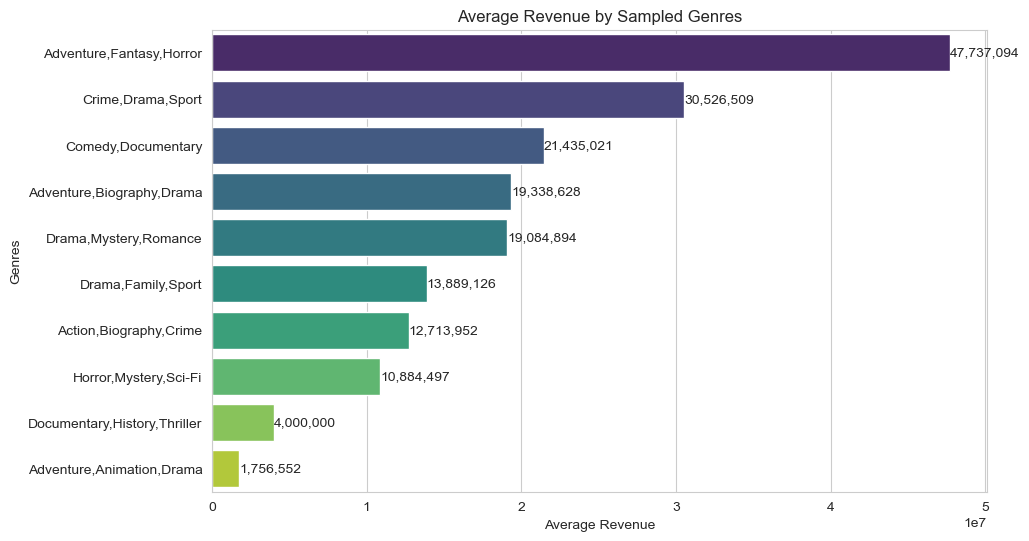

ANOVA F-statistic: 1.5674078424071114, p-value: 9.696794517068207e-09
Reject H0: At least one genre has a different average revenue.


In [99]:
import random

def test_hypothesis_2(df, num_visualize=5):
    # One-hot encode genre combinations to count frequency of each genre across the dataset.
    # This is useful if you later want to visualize or filter by the most common genres.
    genre_counts = df['genres'].str.get_dummies(sep=', ').sum().sort_values(ascending=False)

     # --- Revenue Aggregation by Genre Combination ---
    # Group by exact genre combination string (e.g., 'Action, Comedy') and compute average revenue.
    # Sorting helps in identifying the highest-performing genre combinations.
    genre_revenue = df.groupby('genres')['tmdb_revenue'].mean().reset_index()
    genre_revenue = genre_revenue.sort_values(by='tmdb_revenue', ascending=False)  # Sort by revenue

    # --- ANOVA Test Across Genre Combinations ---
    # Group revenue values by each genre combination to create independent samples.
    # ANOVA (F-test) is used to determine whether at least one group mean is significantly different.
    genre_groups = [group['tmdb_revenue'].values for name, group in df.groupby('genres')]
    f_stat, p_value = stats.f_oneway(*genre_groups)

    # --- Visualization: Sample Genre Combinations ---
    # Randomly select a subset of genre combinations to keep the chart readable.
    # This avoids visual overload when there are many unique combinations.
    sampled_genres = random.sample(list(genre_revenue['genres']), min(num_visualize, len(genre_revenue)))
    genre_revenue_sampled = genre_revenue[genre_revenue['genres'].isin(sampled_genres)]

    # Create a horizontal bar chart for sampled genres
    plt.figure(figsize=(10, 6))
    sns.barplot(x='tmdb_revenue', y='genres', data=genre_revenue_sampled, palette='viridis')
    plt.title('Average Revenue by Sampled Genres')
    plt.xlabel('Average Revenue')
    plt.ylabel('Genres')

    # Add data labels
    for index, value in enumerate(genre_revenue_sampled['tmdb_revenue']):
        plt.text(value, index, f'{value:,.0f}', va='center')

    plt.show()

    print(f'ANOVA F-statistic: {f_stat}, p-value: {p_value}')

    #Decision
    if p_value < 0.05:
        print("Reject H0: At least one genre has a different average revenue.")
    else:
        print("Do not reject H0: No significant difference in average revenue among genres.")
test_hypothesis_2(full_df_cleaned,num_visualize=10)

Hypothesis 3

H₀: There is no correlation between runtime and revenue (i.e., the correlation coefficient is zero).

H₁: There is a correlation between runtime and revenue (i.e., the correlation coefficient is not equal to zero).

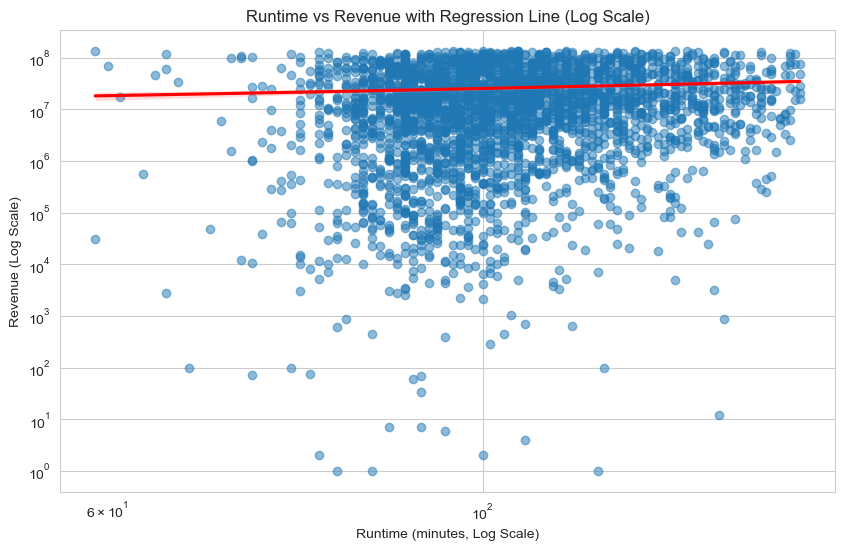

Correlation coefficient: 0.08873001205406453, p-value: 9.747796325984326e-07
Reject H0: There is a significant correlation between runtime and revenue.


In [100]:
def test_hypothesis_3(df):
    # --- Visualization: Runtime vs Revenue ---
    # Create a scatterplot with a regression line to visually assess the relationship
    # between runtime and revenue. A logarithmic scale is used for both axes to
    # handle skewed distributions and to better visualize multiplicative relationships.
    plt.figure(figsize=(10, 6))
    sns.regplot(x='runtimeMinutes', y='tmdb_revenue', data=df_filtered, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title('Runtime vs Revenue with Regression Line (Log Scale)')
    plt.xlabel('Runtime (minutes, Log Scale)')
    plt.ylabel('Revenue (Log Scale)')
    plt.grid(True)
    plt.show()

    # --- Correlation Analysis ---
    # Perform Pearson correlation test to measure the strength and direction of the linear
    # relationship between runtime and revenue. Assumes linearity in raw scale.
    # (May need log transformation beforehand for better interpretability.)
    correlation, p_value = stats.pearsonr(df_filtered['runtimeMinutes'], df_filtered['tmdb_revenue'])
    print(f'Correlation coefficient: {correlation}, p-value: {p_value}')

    #Decision
    if p_value < 0.05:
        print("Reject H0: There is a significant correlation between runtime and revenue.")
    else:
        print("Do not reject H0: No significant correlation between runtime and revenue.")
test_hypothesis_3(full_df_cleaned)

 Hypothesis 4: Do Ratings Predict Profit?

H₀: There is no correlation between audience ratings (IMDb or Rotten Tomatoes) and revenue (i.e., the correlation coefficient is zero).

H₁: There is a correlation between audience ratings (IMDb or Rotten Tomatoes) and revenue (i.e., the correlation coefficient is not equal to zero).

[H4a] IMDb Rating vs Profit: Spearman r = 0.036, p = 0.13838
Result: Do not reject H₀
[H4b] RT Freshness vs Profit: r = -0.013, p = 0.59623
Result: Do not reject H₀


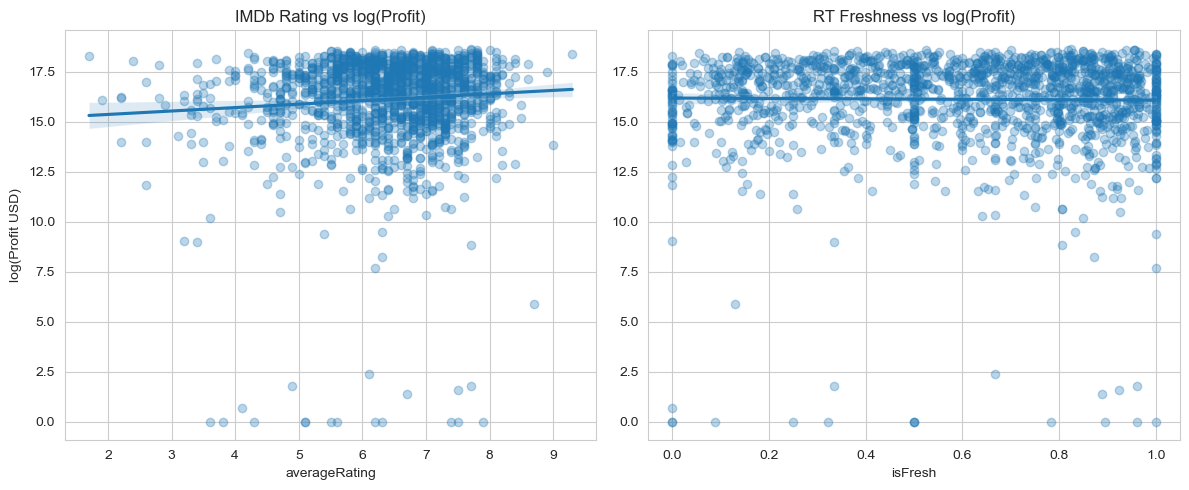

In [101]:
from scipy.stats import spearmanr, pointbiserialr


# Exclude rows with missing or negative profit values to ensure valid log transformation
df4 = full_df_cleaned.copy()
df4 = df4[df4['tmdb_profit'].notna()]
df4 = df4[df4['tmdb_profit'] > -1]  # avoid log1p errors for negative profits
df4['log_profit'] = np.log1p(df4['tmdb_profit'])


# --- Hypothesis Test [H4a]: IMDb Rating vs. Profit (Spearman Rank Correlation) ---
# Spearman correlation is appropriate for monotonic, non-linear relationships,
# especially when the data does not meet normality or linearity assumptions.
r4a, p4a = spearmanr(df4['averageRating'], df4['log_profit'])
print(f"[H4a] IMDb Rating vs Profit: Spearman r = {r4a:.3f}, p = {p4a:.5f}")
print("Result:", "Reject H₀ → Significant correlation." if p4a < 0.05 else "Do not reject H₀")

# --- Hypothesis Test [H4b]: Rotten Tomatoes Freshness vs. Profit (Point-Biserial) ---
# Point-Biserial correlation is used for the relationship between a binary categorical
# variable ('isFresh') and a continuous outcome ('log_profit').
r4b, p4b = pointbiserialr(df4['isFresh'], df4['log_profit'])
print(f"[H4b] RT Freshness vs Profit: r = {r4b:.3f}, p = {p4b:.5f}")
print("Result:", "Reject H₀ → Significant correlation." if p4b < 0.05 else "Do not reject H₀")

# --- Data Visualization ---
# Create side-by-side regression plots to support visual interpretation
# of the relationships examined above.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.regplot(x='averageRating', y='log_profit', data=df4, scatter_kws={'alpha': 0.3})
plt.title("IMDb Rating vs log(Profit)")
plt.ylabel("log(Profit USD)")

plt.subplot(1, 2, 2)
sns.regplot(x='isFresh', y='log_profit', data=df4, scatter_kws={'alpha': 0.3})
plt.title("RT Freshness vs log(Profit)")
plt.ylabel("")

plt.tight_layout()
plt.show()
